In [2]:
import os
# os.environ['CXX'] = '/usr/bin/g++'
# os.environ['CXXFLAGS'] = '-I/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include/c++/v1'

#os.environ['CXXFLAGS'] = '-I/Library/Developer/CommandLineTools/usr/lib/clang/16/include -I/Library/Developer/CommandLineTools/SDKs/MacOSX.sdk/usr/include -I/Library/Developer/CommandLineTools/usr/include'
os.environ["PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:" + os.environ["PATH"]
os.environ["PKG_CONFIG_PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/pkgconfig:" + os.environ.get("PKG_CONFIG_PATH", "")
os.environ["LD_LIBRARY_PATH"] = "/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib:" + os.environ.get("LD_LIBRARY_PATH", "")

# Verify if paths are set correctly
print("PATH:", os.environ["PATH"])
print("PKG_CONFIG_PATH:", os.environ["PKG_CONFIG_PATH"])
print("LD_LIBRARY_PATH:", os.environ["LD_LIBRARY_PATH"])

PATH: /Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/envs/gempy_dino/bin:/Users/deepprakashravi/miniforge3/bin:/Users/deepprakashravi/miniforge3/condabin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/Library/TeX/texbin:/usr/local/share/dotnet:~/.dotnet/tools:/usr/local/munki:/usr/local/munkireport:/Users/deepprakashravi/Library/Application Support/JetBrains/Toolbox/scripts:/Users/deepprakashravi/.local/bin:/Users/deepprakashravi/.local/bin:/Users/deepprakashravi/miniforge3/bin:/Users/deepprakashravi/miniforge3/condabin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cry

In [3]:
import dolfin as dl
import ufl

import sys
import os
sys.path.append( os.environ.get('HIPPYLIB_BASE_DIR', "../") )
from hippylib import *

import logging
import math

import matplotlib.pyplot as plt
%matplotlib inline

logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:79: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/Users/deepprakashravi/miniforge3/envs/gempy_dino/lib/python3.10/site-packages/setuptools/_distutils/cmd.py:79: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
    

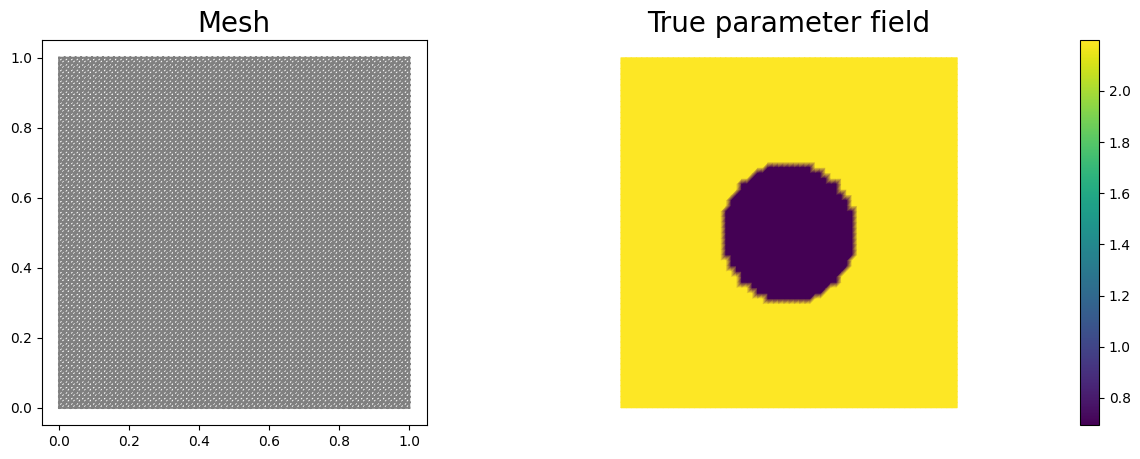

In [4]:
# create mesh and define function spaces
nx = 64
ny = 64
mesh = dl.UnitSquareMesh(nx, ny)
Vm = dl.FunctionSpace(mesh, 'Lagrange', 1)
Vu = dl.FunctionSpace(mesh, 'Lagrange', 2)

# The true and inverted parameter
mtrue_expression = dl.Expression(
    'std::log(2 + 7*(std::pow(std::pow(x[0] - 0.5,2) + std::pow(x[1] - 0.5,2),0.5) > 0.2))',
    degree=5)
mtrue = dl.interpolate(mtrue_expression,Vm)
m = dl.interpolate(dl.Expression("std::log(2.0)", degree=1),Vm)

# define function for state and adjoint
u = dl.Function(Vu)
p = dl.Function(Vu)

# define Trial and Test Functions
u_trial, p_trial, m_trial = dl.TrialFunction(Vu), dl.TrialFunction(Vu), dl.TrialFunction(Vm)
u_test, p_test, m_test = dl.TestFunction(Vu), dl.TestFunction(Vu), dl.TestFunction(Vm)

# initialize input functions
f = dl.Constant(1.0)
u0 = dl.Constant(0.0)

# plot
plt.figure(figsize=(15,5))
nb.plot(mesh,subplot_loc=121, mytitle="Mesh", show_axis='on')
nb.plot(mtrue,subplot_loc=122, mytitle="True parameter field")
plt.show()

In [5]:
# set up dirichlet boundary conditions
def boundary(x,on_boundary):
    return on_boundary

bc_state = dl.DirichletBC(Vu, u0, boundary)
bc_adj = dl.DirichletBC(Vu, dl.Constant(0.), boundary)

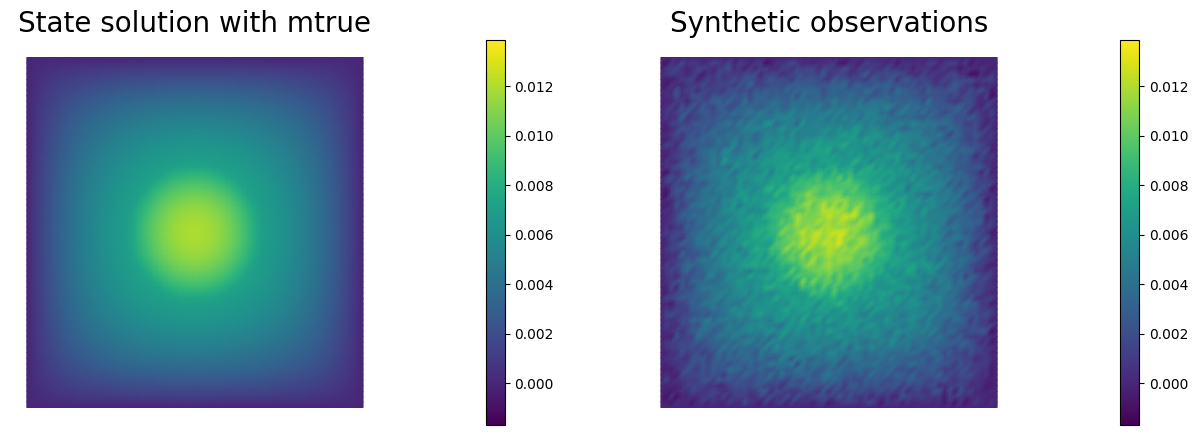

In [6]:
# noise level
noise_level = 0.05

# weak form for setting up the synthetic observations
a_goal = ufl.inner(ufl.exp(mtrue) * ufl.grad(u_trial), ufl.grad(u_test)) * ufl.dx
L_goal = f * u_test * ufl.dx

# solve the forward/state problem to generate synthetic observations
goal_A, goal_b = dl.assemble_system(a_goal, L_goal, bc_state)

utrue = dl.Function(Vu)
dl.solve(goal_A, utrue.vector(), goal_b)

ud = dl.Function(Vu)
ud.assign(utrue)

# perturb state solution and create synthetic measurements ud
# ud = u + ||u||/SNR * random.normal
MAX = ud.vector().norm("linf")
noise = dl.Vector()
goal_A.init_vector(noise,1)
parRandom.normal(noise_level * MAX, noise)
bc_adj.apply(noise)

ud.vector().axpy(1., noise)

# plot
nb.multi1_plot([utrue, ud], ["State solution with mtrue", "Synthetic observations"])
plt.show()


In [7]:
# regularization parameter
gamma = 1e-8

# weak for for setting up the misfit and regularization compoment of the cost
W_equ   = ufl.inner(u_trial, u_test) * ufl.dx
R_equ   = gamma * ufl.inner(ufl.grad(m_trial), ufl.grad(m_test)) * ufl.dx

W = dl.assemble(W_equ)
R = dl.assemble(R_equ)

# refine cost function
def cost(u, ud, m, W, R):
    diff = u.vector() - ud.vector()
    reg = 0.5 * m.vector().inner(R*m.vector() ) 
    misfit = 0.5 * diff.inner(W * diff)
    return [reg + misfit, misfit, reg]

In [8]:
# weak form for setting up the state equation
a_state = ufl.inner(ufl.exp(m) * ufl.grad(u_trial), ufl.grad(u_test)) * ufl.dx
L_state = f * u_test * ufl.dx

# weak form for setting up the adjoint equation
a_adj = ufl.inner(ufl.exp(m) * ufl.grad(p_trial), ufl.grad(p_test)) * ufl.dx
L_adj = -ufl.inner(u - ud, p_test) * ufl.dx

# weak form for setting up matrices
Wum_equ = ufl.inner(ufl.exp(m) * m_trial * ufl.grad(p_test), ufl.grad(p)) * ufl.dx
C_equ   = ufl.inner(ufl.exp(m) * m_trial * ufl.grad(u), ufl.grad(u_test)) * ufl.dx
Wmm_equ = ufl.inner(ufl.exp(m) * m_trial * m_test *  ufl.grad(u),  ufl.grad(p)) * ufl.dx

M_equ   = ufl.inner(m_trial, m_test) * ufl.dx

# assemble matrix M
M = dl.assemble(M_equ)

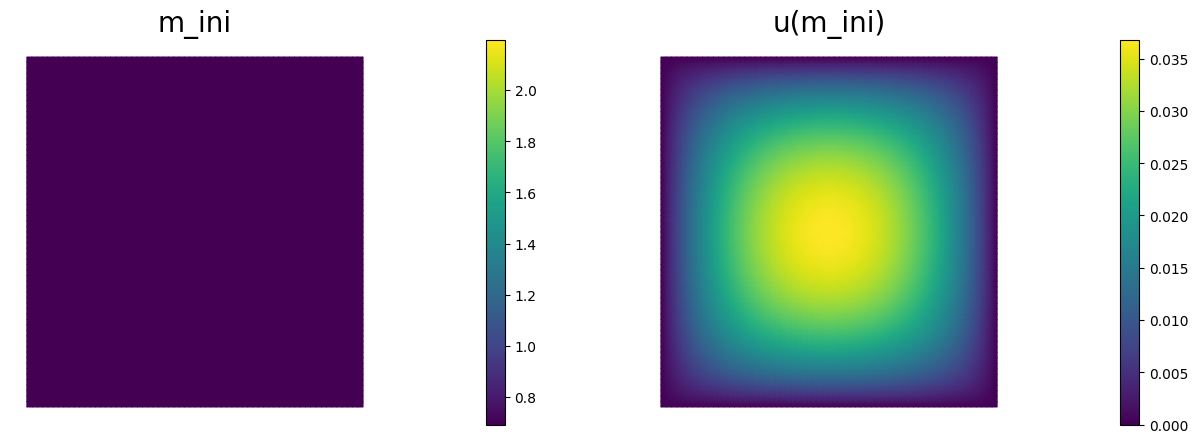

In [9]:
# solve state equation
state_A, state_b = dl.assemble_system (a_state, L_state, bc_state)
dl.solve (state_A, u.vector(), state_b)

# evaluate cost
[cost_old, misfit_old, reg_old] = cost(u, ud, m, W, R)

# plot
plt.figure(figsize=(15,5))
nb.plot(m,subplot_loc=121, mytitle="m_ini", vmin=mtrue.vector().min(), vmax=mtrue.vector().max())
nb.plot(u,subplot_loc=122, mytitle="u(m_ini)")
plt.show()

In [10]:
# Class HessianOperator to perform Hessian apply to a vector
class HessianOperator():
    cgiter = 0
    def __init__(self, R, Wmm, C, A, adj_A, W, Wum, gauss_newton_approx=False):
        self.R = R
        self.Wmm = Wmm
        self.C = C
        self.A = A
        self.adj_A = adj_A
        self.W = W
        self.Wum = Wum
        self.gauss_newton_approx = gauss_newton_approx

        # incremental state
        self.du = dl.Vector()
        self.A.init_vector(self.du,0)

        # incremental adjoint
        self.dp = dl.Vector()
        self.adj_A.init_vector(self.dp,0)

        # auxiliary vectors
        self.CT_dp = dl.Vector()
        self.C.init_vector(self.CT_dp, 1)
        self.Wum_du = dl.Vector()
        self.Wum.init_vector(self.Wum_du, 1)

    def init_vector(self, v, dim):
        self.R.init_vector(v,dim)

    # Hessian performed on v, output as generic vector y
    def mult(self, v, y):
        self.cgiter += 1
        y.zero()
        if self.gauss_newton_approx:
            self.mult_GaussNewton(v,y)
        else:
            self.mult_Newton(v,y)

    # define (Gauss-Newton) Hessian apply H * v
    def mult_GaussNewton(self, v, y):

        # incremental forward
        rhs = -(self.C * v)
        bc_adj.apply(rhs)
        dl.solve (self.A, self.du, rhs)

        # incremental adjoint
        rhs = - (self.W * self.du)
        bc_adj.apply(rhs)
        dl.solve (self.adj_A, self.dp, rhs)

        # Reg/Prior term
        self.R.mult(v,y)

        # Misfit term
        self.C.transpmult(self.dp, self.CT_dp)
        y.axpy(1, self.CT_dp)

    # define (Newton) Hessian apply H * v
    def mult_Newton(self, v, y):

        # incremental forward
        rhs = -(self.C * v)
        bc_adj.apply(rhs)
        dl.solve (self.A, self.du, rhs)

        # incremental adjoint
        rhs = -(self.W * self.du) -  self.Wum * v
        bc_adj.apply(rhs)
        dl.solve (self.adj_A, self.dp, rhs)

        # Reg/Prior term
        self.R.mult(v,y)
        y.axpy(1., self.Wmm*v)

        # Misfit term
        self.C.transpmult(self.dp, self.CT_dp)
        y.axpy(1., self.CT_dp)
        self.Wum.transpmult(self.du, self.Wum_du)
        y.axpy(1., self.Wum_du)

In [11]:
# define parameters for the optimization
tol = 1e-8
c = 1e-4
maxiter = 12
plot_on = False

# initialize iter counters
iter = 1
total_cg_iter = 0
converged = False

# initializations
g, m_delta = dl.Vector(), dl.Vector()
R.init_vector(m_delta,0)
R.init_vector(g,0)

m_prev = dl.Function(Vm)

print ("Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg")

while iter <  maxiter and not converged:

    # assemble matrix C
    C =  dl.assemble(C_equ)

    # solve the adoint problem
    adjoint_A, adjoint_RHS = dl.assemble_system(a_adj, L_adj, bc_adj)
    dl.solve(adjoint_A, p.vector(), adjoint_RHS)

    # assemble W_ua and R
    Wum = dl.assemble (Wum_equ)
    Wmm = dl.assemble (Wmm_equ)

    # evaluate the  gradient
    CT_p = dl.Vector()
    C.init_vector(CT_p,1)
    C.transpmult(p.vector(), CT_p)
    MG = CT_p + R * m.vector()
    dl.solve(M, g, MG)

    # calculate the norm of the gradient
    grad2 = g.inner(MG)
    gradnorm = math.sqrt(grad2)

    # set the CG tolerance (use Eisenstat–Walker termination criterion)
    if iter == 1:
        gradnorm_ini = gradnorm
    tolcg = min(0.5, math.sqrt(gradnorm/gradnorm_ini))

    # define the Hessian apply operator (with preconditioner)
    Hess_Apply = HessianOperator(R, Wmm, C, state_A, adjoint_A, W, Wum, gauss_newton_approx=(iter<6) )
    P = R + gamma * M
    Psolver = dl.PETScKrylovSolver("cg", amg_method())
    Psolver.set_operator(P)

    solver = CGSolverSteihaug()
    solver.set_operator(Hess_Apply)
    solver.set_preconditioner(Psolver)
    solver.parameters["rel_tolerance"] = tolcg
    solver.parameters["zero_initial_guess"] = True
    solver.parameters["print_level"] = -1

    # solve the Newton system H a_delta = - MG
    solver.solve(m_delta, -MG)
    total_cg_iter += Hess_Apply.cgiter

    # linesearch
    alpha = 1
    descent = 0
    no_backtrack = 0
    m_prev.assign(m)
    while descent == 0 and no_backtrack < 10:
        m.vector().axpy(alpha, m_delta )

        # solve the state/forward problem
        state_A, state_b = dl.assemble_system(a_state, L_state, bc_state)
        dl.solve(state_A, u.vector(), state_b)

        # evaluate cost
        [cost_new, misfit_new, reg_new] = cost(u, ud, m, W, R)

        # check if Armijo conditions are satisfied
        if cost_new < cost_old + alpha * c * MG.inner(m_delta):
            cost_old = cost_new
            descent = 1
        else:
            no_backtrack += 1
            alpha *= 0.5
            m.assign(m_prev)  # reset a

    # calculate sqrt(-G * D)
    graddir = math.sqrt(- MG.inner(m_delta) )

    sp = ""
    print( "%2d %2s %2d %3s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %8.5e %1s %5.2f %1s %5.3e" % \
        (iter, sp, Hess_Apply.cgiter, sp, cost_new, sp, misfit_new, sp, reg_new, sp, \
         graddir, sp, gradnorm, sp, alpha, sp, tolcg) )

    if plot_on:
        nb.multi1_plot([m,u,p], ["m","u","p"], same_colorbar=False)
        plt.show()

    # check for convergence
    if gradnorm < tol and iter > 1:
        converged = True
        print( "Newton's method converged in ",iter,"  iterations")
        print( "Total number of CG iterations: ", total_cg_iter)

    iter += 1

if not converged:
    print( "Newton's method did not converge in ", maxiter, " iterations")

Nit   CGit   cost          misfit        reg           sqrt(-G*D)    ||grad||       alpha  tolcg
 1     1     1.12710e-05   1.12710e-05   1.33967e-11   1.56549e-02   3.79445e-04    1.00   5.000e-01
 2     1     7.77820e-07   7.77783e-07   3.67714e-11   4.68327e-03   5.35012e-05    1.00   3.755e-01
 3     1     3.08490e-07   3.08441e-07   4.91231e-11   9.71861e-04   7.13861e-06    1.00   1.372e-01
 4     6     1.89984e-07   1.60065e-07   2.99187e-08   4.52521e-04   1.00342e-06    1.00   5.142e-02
 5     1     1.84658e-07   1.54724e-07   2.99340e-08   1.03219e-04   6.11408e-07    1.00   4.014e-02
 6    12     1.79056e-07   1.37562e-07   4.14938e-08   1.07309e-04   2.09464e-07    1.00   2.350e-02
 7     5     1.79003e-07   1.38546e-07   4.04574e-08   1.02037e-05   3.55342e-08    1.00   9.677e-03
 8    16     1.79003e-07   1.38617e-07   4.03854e-08   1.37028e-06   2.74966e-09    1.00   2.692e-03
Newton's method converged in  8   iterations
Total number of CG iterations:  43


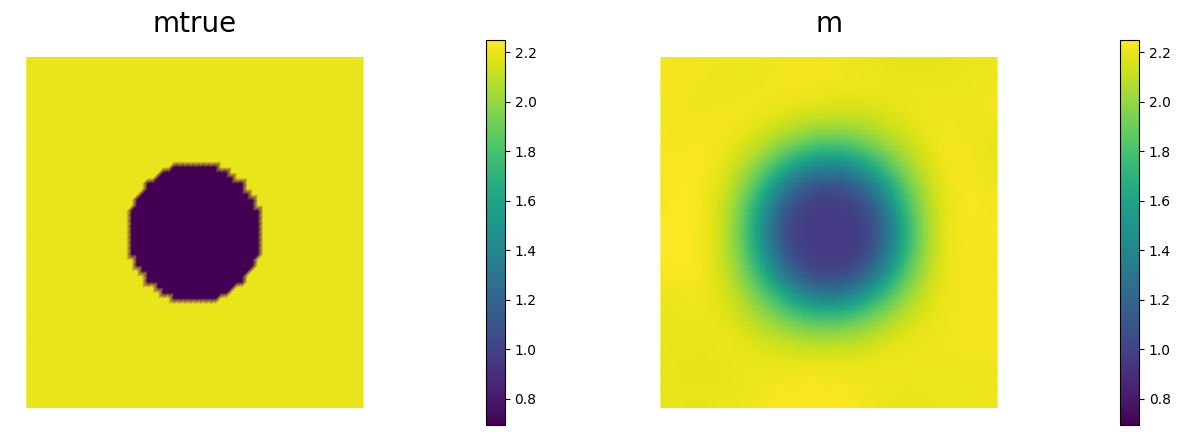

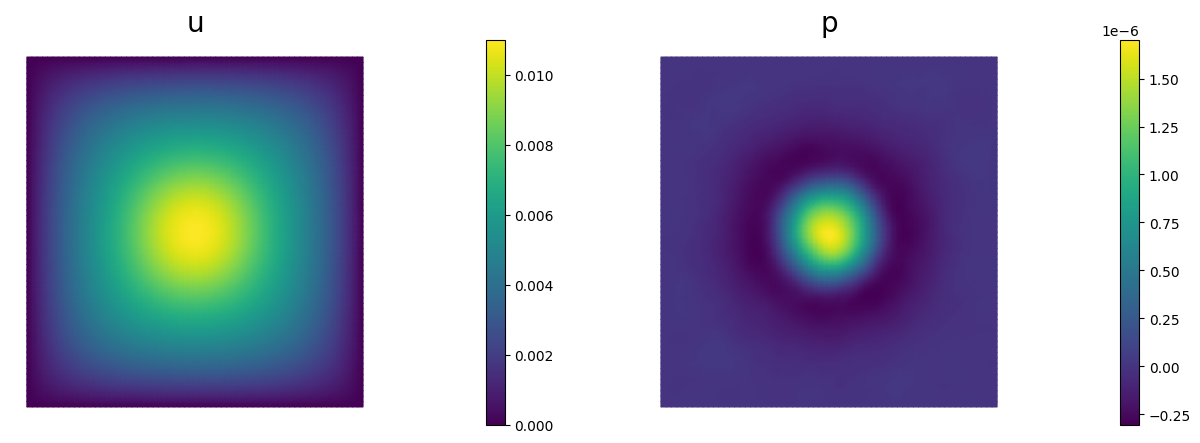

In [12]:
nb.multi1_plot([mtrue, m], ["mtrue", "m"])
nb.multi1_plot([u,p], ["u","p"], same_colorbar=False)
plt.show()